## Initialise

In [4]:
import sys
import os
import numpy as np
from numba import njit
import math
import scipy.optimize
from scipy import special
from scipy import signal

# Plotting import and settinngs
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import axes3d
from matplotlib.ticker import MaxNLocator

linewidth = 5.92765763889 # inch
plt.rcParams["figure.figsize"] = (1.61*linewidth, linewidth)
plt.rcParams['figure.dpi'] = 256
plt.rcParams['font.size'] = 16
plt.rcParams["font.family"] = "Times New Roman"

plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Times New Roman'
plt.rcParams['mathtext.it'] = 'Times New Roman:italic'
plt.rcParams['mathtext.bf'] = 'Times New Roman:bold'

In [5]:
# @njit
def mean_curvature(Z):
    Zy, Zx  = np.gradient(Z)
    Zxy, Zxx = np.gradient(Zx)
    Zyy, _ = np.gradient(Zy)

    H = (Zx**2 + 1)*Zyy - 2*Zx*Zy*Zxy + (Zy**2 + 1)*Zxx
    H = -H/(2*(Zx**2 + Zy**2 + 1)**(1.5))

    return H

# @njit
def gaussian_curvature(Z):
    Zy, Zx = np.gradient(Z)                                                     
    Zxy, Zxx = np.gradient(Zx)                                                  
    Zyy, _ = np.gradient(Zy)                                                    
    K = (Zxx * Zyy - (Zxy ** 2)) /  (1 + (Zx ** 2) + (Zy **2)) ** 2             
    return K

# @njit
def gamma_a(tilde_c, phi, gamma_0, c_0, C_D, xi):
    return gamma_0 + xi * (tilde_c**2 )/ (tilde_c - c_0) + (C_D * phi**2)/2 

# @njit
def Cm(H,d, epsilon):
    return (epsilon/d)*(1-((H*d)**2)/4)
    # return (4*np.pi*epsilon/(d*H**2))*(1-((H*d)**2)/4)

# @njit
def Cm_dot(H, H_dot, d, epsilon):
    return -epsilon*d*H*H_dot/2
    # return 2*(np.pi * epsilon - Cm(H, d, epsilon) )*H_dot/ H

# @njit
def mu(tilde_c, tilde_c_m, mu_0a, R, T, a_0):
    return mu_0a/a_0 +  (R * T/a_0) *np.nan_to_num( np.log((tilde_c / (tilde_c_m - tilde_c))) , 0 ) 

# @njit
def mu_a(H, tilde_c, phi, args):
    K_b, H_0, phi_0, eta_s, lambda_0, epsilon, gamma_0, xi, Pa, R_m, tilde_c_m, mu_0a, mu_0b, k, a_0, c_0, q, R, T, A = args
    return mu(tilde_c, tilde_c_m, mu_0a, R, T, a_0) + ((q*phi)/(2*a_0) )* phi - K_b * H_0 * (2 * H - H_0 * tilde_c)

# @njit
def mu_b(c, c_0, mu_0b, R, T, a_0):
    return mu_0b/a_0 + np.nan_to_num( R * T  * np.log(c /c_0) , 0 ) 

# @njit
def tilde_k(H, tilde_c, phi, c, args):
    K_b, H_0, phi_0, eta_s, lambda_0, epsilon, gamma_0, xi, Pa, R_m, tilde_c_m, mu_0a, mu_0b, k, a_0, c_0, q, R, T, A = args
    return k*(  (c/c_0)*(tilde_c_m-tilde_c) - np.exp(-(mu_0a-mu_0b)/R*T)   )/(a_0*(mu_a(H, tilde_c, phi, args) - mu_b(c, c_0, mu_0b, R, T, a_0)))

# @njit
def tilde(c,c_0):
    return c*c_0/(1+c*c_0)



In [6]:
K_b = 25*1.38e-23*310
H_0 = (1/2)*1e9
d = 4e-9
A = 57.0*(1e-10)**2
gamma_0 =  10*1e-3
Pa = 0.5*1e6

c_0 = 4
a_0 = 50*(1e-10)**2
rho_c = 1496 
c_m = 0.014*rho_c
tilde_c_m = tilde(c_m,c_0)
mu_0a = 1e-4
mu_0b = 1e-4
xi = 1
R = 8.314
T = 310

qe = 1.61e-19
epsilon = 3.5*8.85e-12
q = 0 #1
rho_m =  0 #0.5/(1e-9)**2
R_m = 9.5e6*qe
C_m = 0.5e-4
C_D= 0.003
phi_0 = 1e-9

lambda_0 = 1e-5
eta_s = 1e-5
k = 1e-4

## Monge Represerntation:


\begin{align*}
    \mathfrak{R} = 
    & \Biggl\{ \Bigl[2K_b (2H-H_0\tilde{c})(4H^2 - 2K)-2\gamma_a H - P\Bigr]\dot{h} - \Bigl[\mu_{\sigma}(4H^2 - 2K) - 4\lambda H^2\Bigr]\dot{h}^2   
    + \Bigl[\mathfrak{\mu}(\tilde{c}) + \frac{1}{2}q\,\phi + K_b H_0 (2H-H_0\tilde{c})\Bigr]\dot{\tilde{c}}  -\frac{\mu_c }{2a_0 c_0} \dot{\tilde{c}}^2 \\    
    & + \biggl[ C_m (\phi-\phi_0) + \frac{1}{2}\left( \rho_m+ q\,\tilde{c}\right)\biggr]\dot{\phi} - R_m(C_m\dot{\phi})^2 \Biggr\}A
\end{align*}

\begin{equation*}
    C_m(H,d) = \frac{4\pi\varepsilon}{H^2d}\left( 1 - \frac{1}{4}(Hd)^2\right)
\end{equation*}

\begin{equation*}
    \mathfrak{\mu}(\tilde{c}) = \frac{RT}{a_0}\biggl[ \log\left(\frac{\tilde{c}}{\tilde{c}_m -\tilde{c}}\right) + \frac{\mu_c}{RT} \biggr]
\end{equation*}

$$\phi_0= f_r\phi H$$

$\gamma_a = \gamma_0 + \gamma_\rho(\rho) + \gamma_c(c) + \gamma_\phi(\phi) $ - Active Surface tension
$\gamma_0 $ - Intrinsic Surface tension tension\cite{arroyo2009relaxation,rahimi2012shape}

$\gamma_\rho(c)  = \rho\xi(\rho)$ - Active surface tension \cite{arroyo2009relaxation,torres2019modelling}

$\gamma_c(c)  = c\xi_a(c)$ - Chemical active surface tension \cite{mietke2018dynamics}

$\gamma_\phi(\phi)  = \frac{1}{2}C_m\phi^2$ - Flexoelectric surface tension\cite{galassi2021coupling}

In [4]:
def Rayleighian(X, X_n, dt, x, y, args):
    Ny, Nx = len(y), len(x)
    K_b, H_0 , d, epsilon, P, gamma_0, eta_s, tilde_c_m, a_0, c_0, R, T, mu_c, lambda_val, phi_0, xi, q, rho_m, R_m = args

    tilde_c, phi = X[-2:]
    tilde_c_n, phi_n = X_n[-2:]
    h, h_n = X[:-2].reshape(Ny,Nx), X_n[:-2].reshape(Ny,Nx)

    A = np.trapz(np.trapz(h_n, y, axis=0), x, axis=0)
    H, K = mean_curvature(h_n), gaussian_curvature(h_n)
    C_m = Cm(H,d, epsilon)
    
    P_b   = (2 * K_b * (2 * H - H_0 * tilde_c) * (4 * H**2 - 2 * K) - 2 * gamma_a(tilde_c, phi, gamma_0, c_0, C_m, xi) * H - P)*(h-h_n)/dt - (eta_s * (4 * H**2 - 2 * K) - 4 * lambda_val * H**2)*(h-h_n)/dt**2
    P_c   = (mu(tilde_c, tilde_c_m, mu_c, R, T, a_0) + q*phi/2 - K_b*H_0 * (2 * H - H_0 * tilde_c)) * (tilde_c-tilde_c_n)/dt - (mu_c / (2 * a_0 * c_0)) * (tilde_c-tilde_c_n)/dt**2
    P_phi = ( C_m* (phi - phi_0) + (rho_m + q * tilde_c)/2) * (phi-phi_n)/dt - R_m * (C_m* (phi-phi_n)/dt)**2
    
    I  = P_b + P_c + P_phi
    Rr = np.trapz(np.trapz((I)*A, y, axis=0), x, axis=0)
    
    # print(Rr)
    return abs(Rr)

In [5]:
# Tt, Nt, Nx, Ny = 100, 100, 10, 10
# t, dt = np.linspace(0,Tt,Nt), Tt/Nt
# x, y = np.linspace(-5,5,Nx), np.linspace(-5,5,Nx)

# args = K_b, H_0 , d, epsilon, Pa, gamma_0, eta_s, tilde_c_m, a_0, c_0, R, T, mu_c, lambda_0, phi_0, xi, q, rho_m, R_m

# X = np.zeros([Nt, Ny*Nx + 2])
# X[0,-2:] = np.array([0, C_m])


# index = np.concatenate((np.ravel_multi_index(np.indices([Ny,Nx])[:,:,0], (Ny,Nx)), np.ravel_multi_index(np.indices([Ny,Nx])[:,0,:], (Ny,Nx)), 
#                         np.ravel_multi_index(np.indices([Ny,Nx])[:,:,Nx-1], (Ny,Nx)), np.ravel_multi_index(np.indices([Ny,Nx])[:,Ny-1,:], (Ny,Nx))))

# constraints = [{'type': 'eq', 'fun': lambda x: x[i]} for i in index] + [{'type': 'ineq', 'fun': lambda x: 1-x[-2]}]


# for n in range(Nt-1):
#     opt = scipy.optimize.basinhopping( Rayleighian, x0=X[n], minimizer_kwargs={'args':(X[n], dt, x, y, args),'constraints':constraints})
#     print(opt['success'],n)
    
#     # opt = scipy.optimize.minimize(Rayleighian, X[n], args=(X[n], dt, x, y, args), 
#     #                     constraints=tuple(constraints),  method = 'Nelder-Mead') 
#     X[n+1] = opt['x']
#     # X[n+1,-2] = np.exp(-np.pi*n/25)


In [6]:
# h = X[:,:-2].reshape(Nt,Ny,Nx)
# H = np.array([np.mean(gaussian_curvature(h0)) for h0 in h])

# fig, ax = plt.subplots(3,1, figsize = (25,15))

# ax[0].plot(t[2:], H[2:], label = r'$H$')
# ax[0].legend()

# ax[1].plot(t[2:], X[2:,-2], color =  ax[0]._get_lines.get_next_color(), label = r'$\tilde{c}$')
# ax[1].legend()

# ax[2].plot(t[2:], X[2:,-1], color =  ax[0]._get_lines.get_next_color(), label = r'$\phi$')
# ax[2].legend()

# plt.legend()
# plt.show()

In [7]:
# from IPython.display import clear_output

# for n in range(Nt)[::10]:
#     # Plots grid 
#     clear_output(wait=True)
    
#     fig, ax= plt.subplots(1, 1, figsize=(7,6.5)) 
#     im= ax.pcolor(h[n], edgecolors='k', linewidths=1, vmin=0, vmax= h.max())
#     cbar= fig.colorbar(im) 
#     print(t[n])
#     plt.draw()
#     plt.pause(dt)


## Single Area Segment Vectorised


\begin{align}
|\boldsymbol{x} \rangle\equiv 
\begin{bmatrix}
       H \\
       \tilde{c} \\
       \phi \\
\end{bmatrix}
\end{align}

\begin{align*}
{\mathfrak{R}} = &
\begin{bmatrix}
       H &
       \tilde{c} &
       \phi 
\end{bmatrix}
\begin{bmatrix}
          4K_b     &   -2K_bH_0               &  -C_m\phi_0  \\
        -2K_bH_0   & \frac{RT}{a_0}\left(\frac{1+\tilde{c}_m}{\tilde{c}_m}\right)-2KbH_0^2 &  \frac{1}{2}q  \\
       -C_m\phi_0  & \frac{1}{2}q            &  C_m  \\
\end{bmatrix}
\begin{bmatrix}
       \dot{H} \\
       \dot{\tilde{c}} \\
       \dot{\phi} \\
\end{bmatrix}
 - 
\begin{bmatrix}
       \dot{H} &
       \dot{\tilde{c}} &
       \dot{\phi} 
\end{bmatrix}
\begin{bmatrix}
          \mu_{\sigma} &           0            &  0  \\
           0           &  \frac{\mu_c}{2a_0c_0} &  0 \\
           0           &           0            &  R_mC_m^2  \\
\end{bmatrix}
\begin{bmatrix}
       \dot{H} \\
       \dot{\tilde{c}} \\
       \dot{\phi} \\
\end{bmatrix}
+ 
\begin{bmatrix}
           0   &  \frac{\mu_c}{a_0} - \frac{RT}{a_0}(1-\log\tilde{c}_m) &  \frac{1}{2}\rho_m  \\
\end{bmatrix}
\begin{bmatrix}
       \dot{H} \\
       \dot{\tilde{c}} \\
       \dot{\phi} \\
\end{bmatrix}
\end{align*}

\begin{equation}
    \mathfrak{R}  = \biggl\{ \langle\boldsymbol{x}|\boldsymbol{P}|\dot{\boldsymbol{x}}\rangle - \langle\dot{\boldsymbol{x}}| \boldsymbol{W} |\dot{\boldsymbol{x}} \rangle + \boldsymbol{A} |\dot{\boldsymbol{x}}\rangle \biggr\}A
\end{equation}


In [8]:
def Rayleighian(X, X_n, dt, P, W, C, A):
    I = (X_n.T@P@(X-X_n)/dt - (X-X_n).T@W@(X-X_n)/dt**2 + C@(X-X_n)/dt)
    return abs(I)

In [9]:
# Tt, Nt = 1e-9, 1000
# t, dt = np.linspace(0,Tt,Nt), Tt/Nt
# X = 5*np.zeros([Nt, 3])
# X[0] = np.array([H_0, 0.5, rho_m*d*A/C_m]).T


# P = np.array([ [4*K_b, -2*K_b*H_0, -Cm(X[0,0],d,epsilon)*phi_0], [-2*K_b*H_0, (R*T*(1+tilde_c_m))/(a_0*tilde_c_m)-2*K_b*H_0**2, q/2], [-Cm(X[0,0],d,epsilon)*phi_0,q/2,Cm(X[0,0],d,epsilon)] ])
# W = np.diag([eta_s, mu_c/(2*a_0*c_0), R_m*Cm(X[0,0],d,epsilon)*2])
# C = np.array([0, mu_c/a_0 - (1-np.log(tilde_c_m)), rho_m/2])


# for n in range(Nt-1):
#     opt = scipy.optimize.minimize(Rayleighian, X[0], args=(X[n], dt, P, W, C, A), method = 'Nelder-Mead', constraints = [{'type': 'ineq', 'fun': lambda x: tilde_c_m-x[1]},{'type': 'ineq', 'fun': lambda x: x[1]}])
#     X[n+1] = opt['x']

#     # Concentration 
#     # if n <= Nt/2 :
#     X[n+1,1] = tilde_c_m*np.exp(-0.0001*(n-Nt/2)**2) 
#     # X[n+1,1] = tilde_c_m*np.exp(0.05*(n-Nt)) 
    
#     # Curvature
#     # X[n+1,0] = H_0*np.sin(np.pi*n*Nt/20000)

    
#     # X[n+1,2] = (rho_m*d/A*C_m)*np.exp(-0.01*(n-Nt/2)**2) 

#     P = np.array([ [4*K_b, -2*K_b*H_0, -Cm(X[n+1,0],d,epsilon)*phi_0], [-2*K_b*H_0, (R*T*(1+tilde_c_m))/(a_0*tilde_c_m)-2*K_b*H_0**2, q/2], [-Cm(X[n+1,0],d,epsilon)*phi_0,q/2,Cm(X[n+1,0],d,epsilon)] ])
#     W = np.diag([eta_s, mu_c/(2*a_0*c_0), R_m*Cm(X[n+1,0],d,epsilon)*2])
#     C = np.array([0, mu_c/a_0 - (1-np.log(tilde_c_m)), rho_m/2])



In [10]:
# fig, ax = plt.subplots(3,1, figsize = (25,15))

# ax[0].plot(t[2:], X[2:,0], label = r'$H$')
# ax[0].legend()

# ax[1].plot(t[2:], X[2:,1], color =  ax[0]._get_lines.get_next_color(), label = r'$\tilde{c}$')
# ax[1].legend()

# ax[2].plot(t[2:], X[2:,2], color =  ax[0]._get_lines.get_next_color(), label = r'$\phi$')
# ax[2].legend()

# plt.legend()
# plt.show()

## Single Area Segment

Applying this simplification to the Rayleighian we define a Rayleighian for a finite membrane patch:  

\begin{align}
\begin{split}
    \mathfrak{R} = 
    & \Biggl\{ 2K_b (2H-H_0\tilde{c})\dot{H} - C_m\phi\phi_0\dot{H}  + \left(\frac{2\mu_{\sigma}+\lambda}{H^2}\right)\dot{H}^2 \\    
    & - \Bigl(\phi^2+2\phi_0\phi H \Bigr)\dot{C}_m + \frac{\gamma_aH-P}{H^2} \dot{H} \\
    & + \Bigl(\mathfrak{\mu}(\tilde{c}) + \frac{1}{2}\frac{q\phi}{a_0}- K_b H_0 (2H-H_0\tilde{c})\Bigr)\dot{\tilde{c}} + \frac{\mu_c }{2a_0 c_0} \dot{\tilde{c}}^2\\
    & + \biggl[ -C_m (\phi+\phi_0H) + \frac{1}{2}\left( \rho_m+ \frac{q\tilde{c}}{a_0}\right)\biggr]\dot{\phi}\\
    & + R_m\cdot\Bigl[ C_m(\dot{\phi}+\phi_0\dot{H}) + \dot{C}_m(\phi+\phi_0H) \Bigr]^2\Biggr\}A  ,
\end{split}
\end{align}
where the evolution of areal capacitance is given by

\begin{align}
    \dot{C}_m  = -\frac{\varepsilon d}{2}H \dot{H} . 
\end{align}


In [11]:
def Rayleighian(X, X_n, dt, args):

    K_b, H_0, phi_0, eta_s, lambda_0, epsilon, gamma_0, xi, Pa, R_m, tilde_c_m, mu_0a, mu_0b, k, a_0, c_0, q, R, T, A = args
    
    H, c, phi = X
    H_n, c_n, phi_n = X_n
    tilde_c, tilde_c_n = tilde(c,c_0), tilde(c_n,c_0)

    H_dot, tilde_c_dot, phi_dot = H-H_n/dt, tilde_c-tilde_c_n/dt, phi-phi_n/dt

    C_m =  Cm(H, d, epsilon)
    C_m_dot = Cm_dot(H, H_dot, d, epsilon)
    
    R = ( 
        2 * K_b * (2 * H - H_0 * tilde_c) * H_dot 
        - C_m * phi * phi_0 * H_dot  
        + (2 * eta_s + lambda_0)*float(H and H_dot/H)**2 
        - (phi**2 + 2 * phi_0 * phi * H) * C_m_dot 
        + (gamma_a(tilde_c, phi, gamma_0, c_0, C_D, xi) * H - Pa) * H_dot * float(H and 1/H)**2
        
        + ( 0 +
             mu(tilde_c, tilde_c_m, mu_0a, R, T, a_0) 
            +((q*phi)/(2*a_0) )* phi - K_b * H_0 * (2 * H - H_0 * tilde_c)
            + mu_b(c, c_0, mu_0b, R, T, a_0)
               ) *tilde_c_dot 


        +  tilde_c_dot**2 /(tilde_k(H, tilde_c, phi, c, args) * a_0)

        + (
            - C_m * (phi + phi_0*H) 
           + 0.5 * (rho_m + (q * tilde_c)/a_0)
           ) * phi_dot 
        + R_m * (C_m*(phi_dot+phi_0*H_dot) - C_m_dot*(phi+phi_0*H))**2 
        ) * A

    return abs(R)

In [12]:
def wavePulse(t, A, f, wavelets, Tt, A_0):
    '''  '''
    Nwavelets = 2*wavelets + 1

    fmin   = Nwavelets/Tt
    fdelta = f*Tt/Nwavelets%1
    f1     = f*fmin/( f + (math.ceil(fdelta)-fdelta)*fmin )

    t0 = 1/2*(Tt-1/f1)
    t1 = - Tt/2  - 3/(2*f1) + 3/f1*(wavelets%2)

    return A_0 + A/2 * ( 1-int(wavelets != 0)*signal.square(np.pi*f1*(t+t1) ) ) * np.sin(2*np.pi*f*(t-t0))


def wavePeriod(f, wavelets, Tt):
    ''' '''
    Nwavelets = 2*wavelets + 1 
    fmin      = Nwavelets/Tt
    fdelta    = f*Tt/Nwavelets%1
    f1        = f*fmin/( f + (math.ceil(fdelta)-fdelta)*fmin )

    periods   = np.sort(np.array([ abs(Tt/2 + ( (1+2*(wavelets-1))/(2*f1) ) -  i/f1) for i in range(Nwavelets-1)] ))

    return  periods[periods<=Tt]

def periodConditions(t, periods):
    p1 = periods[::2]
    p2 = np.roll(periods,-1)[::2]

    period = [(p1[i] <= t <= p2[i]) for i in range(len(p1))]

    return bool(np.sum(period))

def PulseConstraints(self, t):
    ''' '''
    Xc = wavePulse(t, self.A, self.f, self.wavelets, self.Tt, self.A_0 )

    if periodConditions(t, self.periods) :
        return  [{'type': 'eq', 'fun': lambda x: x[0] - Xc }] + [{'type': 'eq', 'fun': lambda x: x[1] }]
        
    else: 
        return [{'type': 'eq', 'fun': lambda x: x[1] }]


class Constraints:
    '''  '''
    def __init__(self, constraint, dt, Tt, Nt, c_m = 30, t0 = 1e-6, A = 1/1e-5, f = 1.8e7, A_0=1e6, wavelets=1 ):
        ''' '''
        self.constraint = constraint
        self.Tt = Tt
        self.dt = dt
        self.Nt = Nt

        self.c_m = c_m
        self.t0  = t0 

        self.A = A
        self.f = f
        self.A_0 = A_0
        self.wavelets = wavelets
        self.periods = wavePeriod(f, wavelets, Tt)
            
        if self.constraint == 'None':
            self.ConstraintFunction = lambda self, t : [{'type': 'eq', 'fun': lambda x: x[1] }]

        elif self.constraint == 'Gaussian':
            self.ConstraintFunction = lambda self, t : [{'type': 'eq', 'fun': lambda x: x[1] -  self.c_m*np.exp(-0.1*self.Nt*((t - self.Tt/2)/self.Tt)**2)}]

        elif self.constraint == 'Sigmoid':
            self.ConstraintFunction = lambda self, t : [{'type': 'eq', 'fun': lambda x: x[1] -  1/(1+self.c_m*np.exp(-0.1*( t - self.Tt/2 )/self.dt))}]
        
        elif self.constraint == 'Skewwed':
            self.ConstraintFunction = lambda self, t : [{'type': 'eq', 'fun': lambda x: x[1] -  (self.c_m/2)*np.exp(-0.015*self.Nt*((t-self.t0)/self.Tt)**2)*(1-special.erf(-1e8*(t-self.t0)) ) }]
            
        elif self.constraint == 'Ultrasound':
            self.ConstraintFunction = lambda self, t : [{'type': 'eq', 'fun': lambda x: x[0] - wavePulse(t, self.A, self.f, self.wavelets, self.Tt, self.A_0 ) }]
        
        elif self.constraint == 'UltrasoundPulse':
            self.ConstraintFunction = PulseConstraints

        else:
            raise Exception("No Valid Constraint")

    def changeUltrasoundParameters(self, A = 1/1e-5, f = 1.8e7, A_0=1e6, wavelets=1):
        ''' '''
        self.A = A
        self.f = f
        self.A_0 = A_0
        self.wavelets = wavelets
        self.periods = wavePeriod(f, wavelets, self.Tt)


    def changeDosingParameters(self, c_m = 30, t0 = 1e-6):
        ''' '''
        self.c_m = c_m
        self.t0  = t0 
    
    def constraintList(self, t):
        ''' '''
        return self.ConstraintFunction(self, t)

In [13]:
#--------------------------------------------Initialisation------------------------------------------
Tt, Nt = 1e-6, 1000
t, dt = np.linspace(0,Tt,Nt), Tt/Nt

X = np.zeros([Nt, 3])
Xerr = np.zeros([Nt])
X[0] = np.array([H_0, 0.1, C_m]).T

constraint = Constraints('None', dt, Tt, Nt)
arg  = ( K_b, H_0, phi_0, eta_s, lambda_0, epsilon, gamma_0, xi, Pa, R_m, tilde_c_m, mu_0a, mu_0b, k, a_0, c_0, q, R, T, A )

#-----------------------------------------------Minimisation------------------------------------------
for n in range(Nt-1):
    opt = scipy.optimize.basinhopping( Rayleighian, x0=X[0], minimizer_kwargs={'args':(X[n], dt, arg), 'constraints': constraint.constraintList(t[n]) })

    if constraint.constraint == 'UltrasoundPulse':
        if periodConditions(t[n], constraint.periods) == False :
                constraint.changeUltrasoundParameters(A_0=X[n+1])
        
    X[n+1] = opt['x']
    Xerr[n+1] = opt['success']
    
    print(opt['success'], n)
    

C:\Users\Joshg\AppData\Local\Temp\ipykernel_3608\2429230110.py:36: RuntimeWarning: divide by zero encountered in log
  return mu_0a/a_0 +  (R * T/a_0) *np.nan_to_num( np.log((tilde_c / (tilde_c_m - tilde_c))) , 0 )
C:\Users\Joshg\AppData\Local\Temp\ipykernel_3608\2429230110.py:36: RuntimeWarning: overflow encountered in scalar multiply
  return mu_0a/a_0 +  (R * T/a_0) *np.nan_to_num( np.log((tilde_c / (tilde_c_m - tilde_c))) , 0 )
C:\Users\Joshg\AppData\Local\Temp\ipykernel_3608\2429230110.py:45: RuntimeWarning: divide by zero encountered in log
  return mu_0b/a_0 + np.nan_to_num( R * T  * np.log(c /c_0) , 0 )
C:\Users\Joshg\AppData\Local\Temp\ipykernel_3608\458940136.py:29: RuntimeWarning: divide by zero encountered in scalar divide
  +  tilde_c_dot**2 /(tilde_k(H, tilde_c, phi, c, args) * a_0)


C:\Users\Joshg\AppData\Local\Temp\ipykernel_3608\2429230110.py:36: RuntimeWarning: invalid value encountered in log
  return mu_0a/a_0 +  (R * T/a_0) *np.nan_to_num( np.log((tilde_c / (tilde_c_m - tilde_c))) , 0 )
C:\Users\Joshg\AppData\Local\Temp\ipykernel_3608\2429230110.py:45: RuntimeWarning: invalid value encountered in log
  return mu_0b/a_0 + np.nan_to_num( R * T  * np.log(c /c_0) , 0 )
C:\Users\Joshg\AppData\Local\Temp\ipykernel_3608\2429230110.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  return k*(  (c/c_0)*(tilde_c_m-tilde_c) - np.exp(-(mu_0a-mu_0b)/R*T)   )/(a_0*(mu_a(H, tilde_c, phi, args) - mu_b(c, c_0, mu_0b, R, T, a_0)))


True 0


C:\Users\Joshg\AppData\Local\Temp\ipykernel_3608\458940136.py:16: RuntimeWarning: invalid value encountered in scalar add
  2 * K_b * (2 * H - H_0 * tilde_c) * H_dot


True 1
True 2
True 3
True 4
True 5
True 6
True 7
True 8
True 9
True 10
True 11
True 12
True 13
True 14
True 15
True 16
True 17
True 18
True 19
True 20
True 21
False 22
True 23
True 24
True 25
True 26
True 27
True 28
True 29
True 30
True 31
True 32
True 33
True 34
True 35
True 36
True 37
True 38
True 39
True 40
True 41
True 42
True 43
True 44
True 45
True 46
True 47
False 48
True 49
True 50
True 51
True 52
True 53
True 54
True 55
True 56
True 57
True 58
True 59
True 60
True 61
True 62
True 63
True 64
True 65
True 66
True 67
True 68
True 69
True 70
True 71
True 72
True 73
True 74
True 75
True 76
True 77
True 78
True 79
True 80
True 81
True 82
True 83
True 84
True 85
True 86
True 87
True 88
True 89
True 90
True 91
True 92
True 93
True 94
True 95
True 96
True 97
True 98
True 99
True 100
True 101
True 102
True 103
True 104
True 105
True 106
True 107
True 108
True 109
True 110
True 111
True 112
False 113
True 114
False 115
True 116
True 117
True 118
True 119
True 120
True 121
True 122
True 1

# Plots

In [ ]:
# A = 1/1e-5
# f = 1.8e7
# A_0=1e6
# wavelets = 3
# Tt, Nt = 1e-6, 1000
# t, dt = np.linspace(0,Tt,Nt), Tt/Nt


# periods = wavePeriod(f, wavelets, Tt)
# print(periodConditions(0.2e-6, periods))

# plt.plot(t, wavePulse(t, A, f, wavelets, Tt, A_0) )
# for i in  periods:
#     plt.vlines(i, A_0-A, A_0+A, 'r')


# Tt, Nt = 10e-6, 100
# t, dt = np.linspace(0,Tt,Nt), Tt/Nt
# Tt, Nt = 10e-6, 10000
# t, dt = np.linspace(0,Tt,Nt), Tt/Nt
# Xc = np.append(np.append(t*0, c_m/2*np.exp(-0.0015*Nt*((t- Tt/5)/Tt)**2)*(1-special.erf(-0.5e8*(t-Tt/5)))), np.append(t*0,t*0 ))

# Tt, Nt = 4*Tt, 4*Nt
# t, dt = np.linspace(0,Tt,Nt), Tt/Nt

# plt.plot(t,Xc)
# plt.plot(t,c_m*t**0)

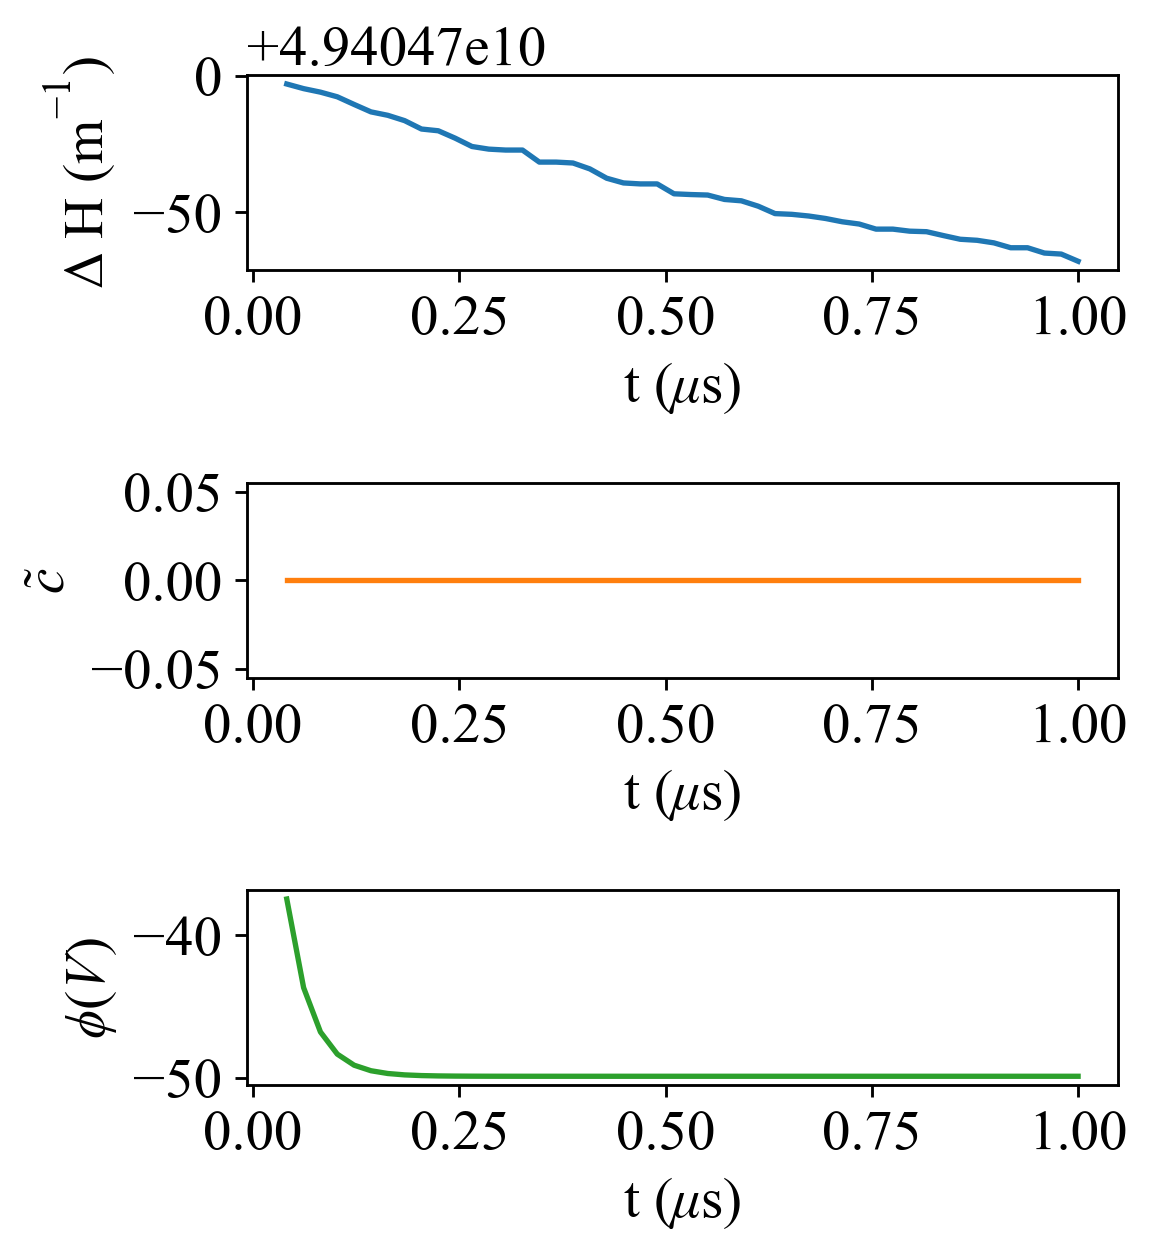

In [31]:
fig, ax = plt.subplots(3,1, figsize = (1.61*linewidth/2, 1.75*linewidth/2))

ax[0].plot(t[2:2300]*1e6, (X[2:2300,0]-5e8), label = r'$H$ (nm^1)')
ax[0].set_ylim(ax[0].get_ylim()[0], ax[0].get_ylim()[1])
ax[0].set_xlabel(r't ($\mu$s)')
ax[0].set_ylabel('$\Delta$ H (m$^{-1}$)', rotation = 90)
# ax[0].legend()

plot1 = ax[1].plot(t[2:2300]*1e6, tilde(X[2:2300,1], c_0), color =  ax[0]._get_lines.get_next_color(), label = r'$c$')
ax[1].set_xlabel(r't ($\mu$s)')
ax[1].set_ylabel(r'$\tilde{c}$', rotation = 90)
# ax[1].set_ylim(0, ax[1].get_ylim()[1])

# ax1 = ax[1].twinx()
# ax1.plot(t[2:], tilde(X[2:,1], c_0), ':', color =  ax[1].lines[-1].get_color(), label = r'$\tilde{c}$')
# ax1.set_ylabel(r'$\tilde{c}$', rotation = 0)
# ax1.set_ylim(0, ax1.get_ylim()[1])

# handles0, labels0 = ax[1].get_legend_handles_labels()
# handles1, labels1 = ax1.get_legend_handles_labels()
# ax[1].legend(handles0+handles1, labels0+labels1, loc=[0.75, 0.4], frameon=False)

ax[2].plot(t[2:2300]*1e6, X[2:2300,2], color =  ax[0]._get_lines.get_next_color(), label = r'$\phi$')
ax[2].set_xlabel(r't ($\mu$s)', rotation = 0)
ax[2].set_ylabel(r'$\phi (V)$', rotation = 90)
ax[2].set_ylim(ax[2].get_ylim()[0], ax[2].get_ylim()[1])
# ax[2].legend()

# ax[2].set_ylim(0,10)

fig.tight_layout()
plt.show()

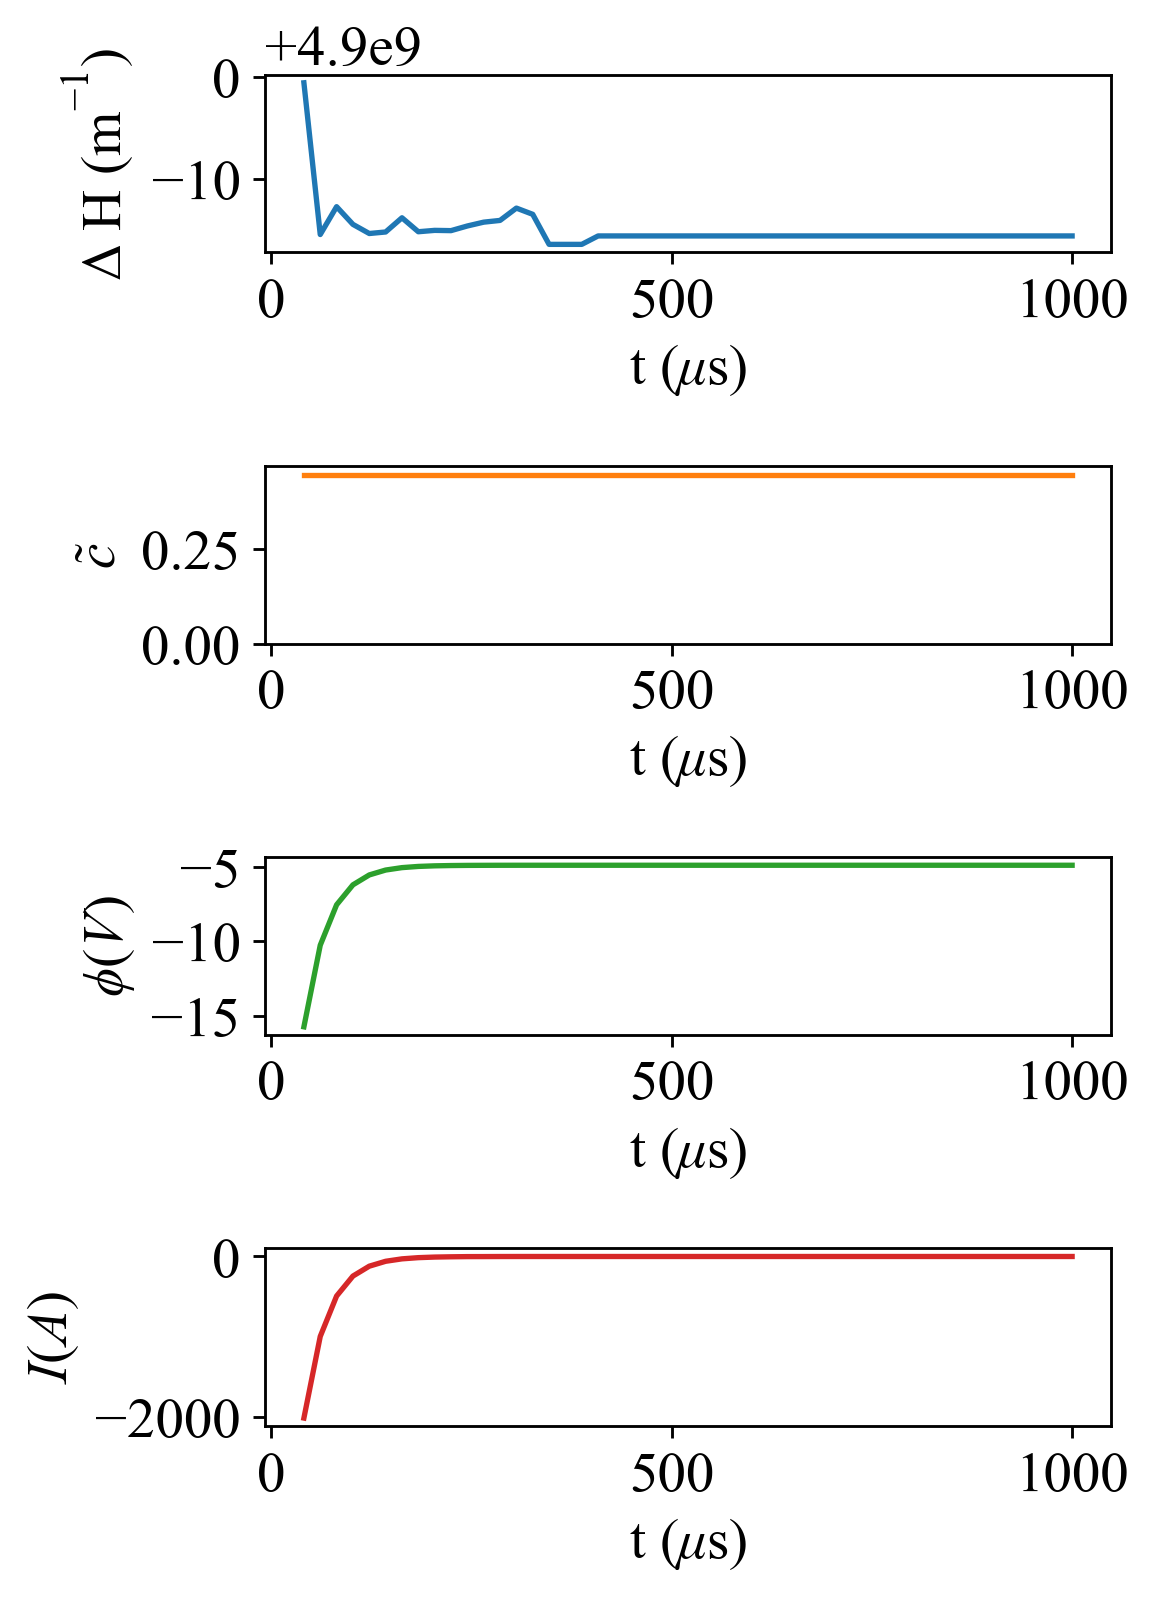

In [20]:
filename = '9None'
# filename = '5Gaussian'
# filename = '0Sigmoid'
# filename = '2Skewwed'
# filename = '6UltrasoundPulse'

I = np.loadtxt('..' + os.sep + 'data' + os.sep + 'I-' + filename + '.csv', delimiter=',')
# V = np.loadtxt('..' + os.sep + 'data' + os.sep + 'V-' + filename + '.csv', delimiter=',')
X = np.loadtxt('..' + os.sep + 'data' + os.sep + 'X-' + filename + '.csv', delimiter=',')
t = np.loadtxt('..' + os.sep + 'data' + os.sep + 't-' + filename + '.csv', delimiter=',')

#-------------------------------------------Plot Data------------------------------------------
fig, ax = plt.subplots(4,1, figsize = (1.61*linewidth/2, 2.2*linewidth/2))

ax[0].plot(t[2:2300]*1e6, (X[2:2300,0]), label = r'$H$ (nm^1)') 
ax[0].set_ylim(ax[0].get_ylim()[0], ax[0].get_ylim()[1])
ax[0].set_xlabel(r't ($\mu$s)')
ax[0].set_ylabel('$\Delta$ H (m$^{-1}$)', rotation = 90)
# ax[0].legend()

ax[1].plot(t[2:2300]*1e6, tilde(X[2:2300,1], c_0), color =  ax[0]._get_lines.get_next_color(), label = r'$c$')
ax[1].set_xlabel(r't ($\mu$s)')
ax[1].set_ylabel(r'$\tilde{c}$', rotation = 90)
ax[1].set_ylim(0, ax[1].get_ylim()[1])

# ax1 = ax[1].twinx()
# ax1.plot(t[2:], tilde(X[2:,1], c_0), ':', color =  ax[1].lines[-1].get_color(), label = r'$\tilde{c}$')
# ax1.set_ylabel(r'$\tilde{c}$', rotation = 0)
# ax1.set_ylim(0, ax1.get_ylim()[1])

# handles0, labels0 = ax[1].get_legend_handles_labels()
# handles1, labels1 = ax1.get_legend_handles_labels()
# ax[1].legend(handles0+handles1, labels0+labels1, loc=[0.75, 0.4], frameon=False)

ax[2].plot(t[2:2300]*1e6, X[2:2300,2], color =  ax[0]._get_lines.get_next_color(), label = r'$\phi$')
ax[2].set_xlabel(r't ($\mu$s)', rotation = 0)
ax[2].set_ylabel(r'$\phi (V)$', rotation = 90)
ax[2].set_ylim(ax[2].get_ylim()[0], ax[2].get_ylim()[1])
# ax[2].legend()
# ax[2].set_ylim(0,10000)

ax[3].plot(t[2:2300]*1e6, I[2:2300], color =  ax[0]._get_lines.get_next_color(), label = r'$I$')
ax[3].set_xlabel(r't ($\mu$s)', rotation = 0)
ax[3].set_ylabel(r'$I (A)$', rotation = 90)
ax[3].set_ylim(ax[3].get_ylim()[0], ax[3].get_ylim()[1])
# ax[3].legend()
# ax[3].set_ylim(0,0.1)

# ax[4].plot(t[2:2300]*1e6, V[2:2300], color =  ax[0]._get_lines.get_next_color(), label = r'$I$')
# ax[4].set_xlabel(r't ($\mu$s)', rotation = 0)
# ax[4].set_ylabel(r'$V (mV)$', rotation = 90)
# ax[4].set_ylim(ax[4].get_ylim()[0], ax[4].get_ylim()[1])
# # ax[4].legend()
# # ax[4].set_ylim(0,0.1)

fig.tight_layout()

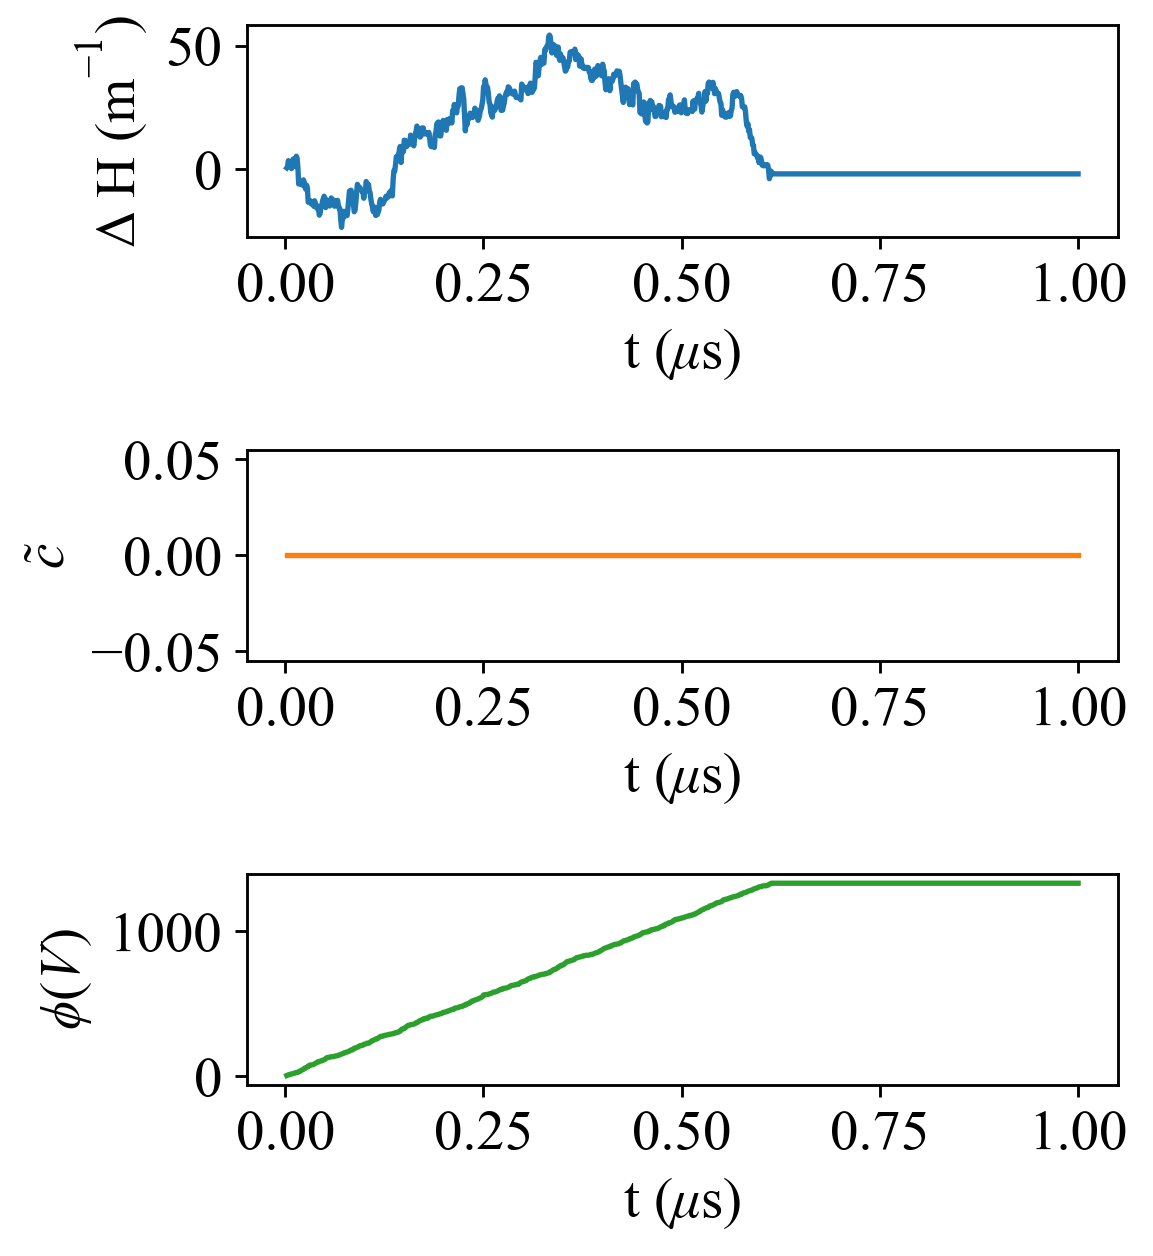

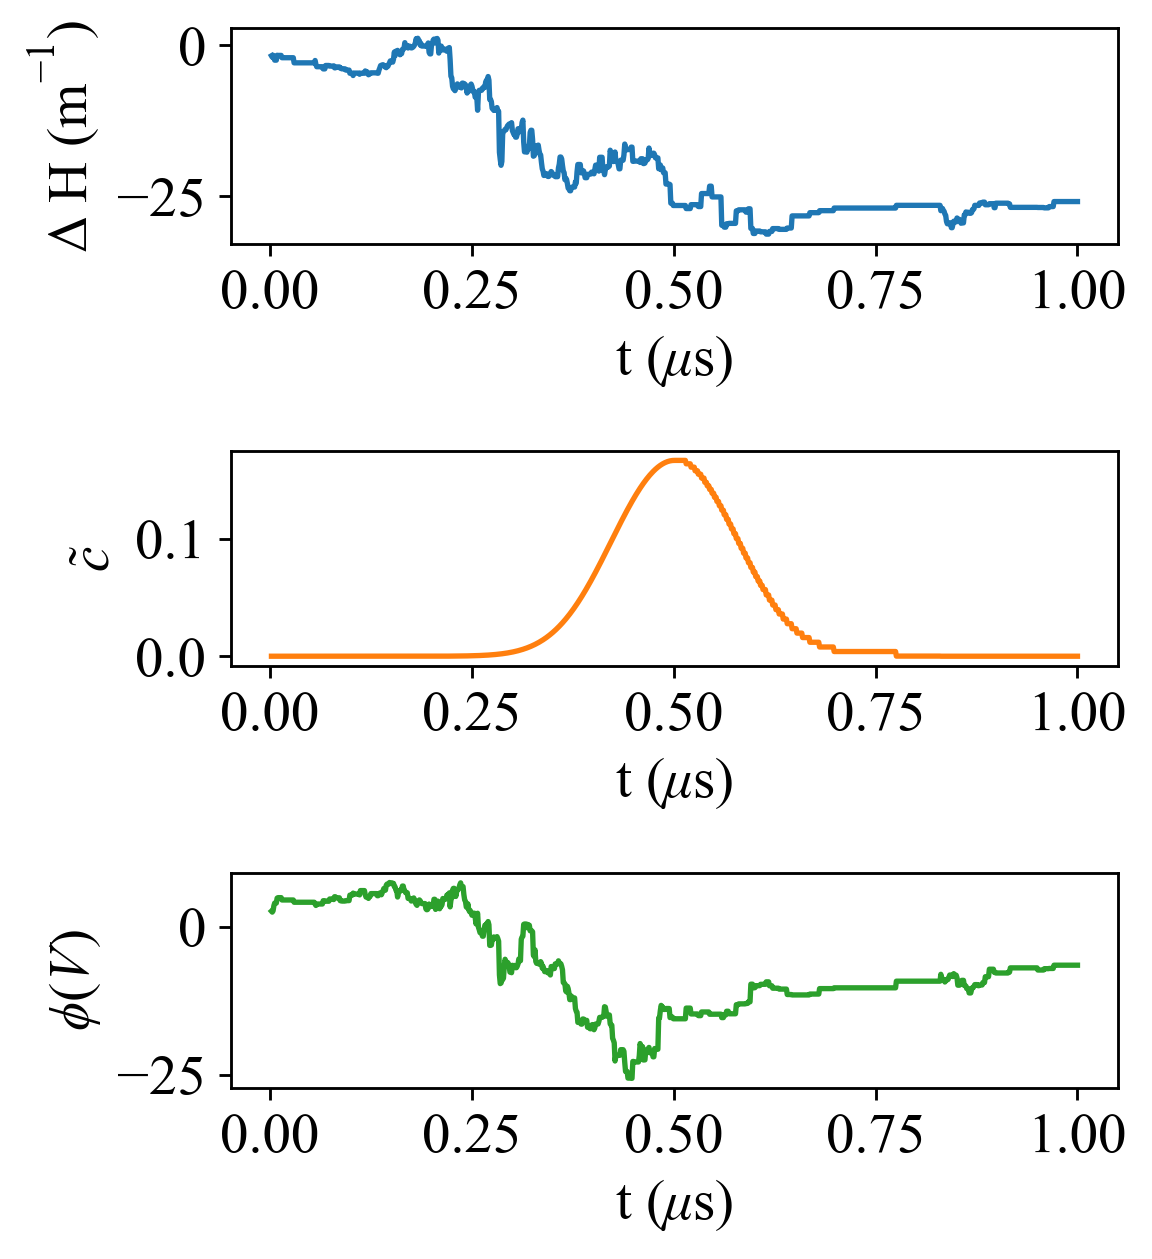

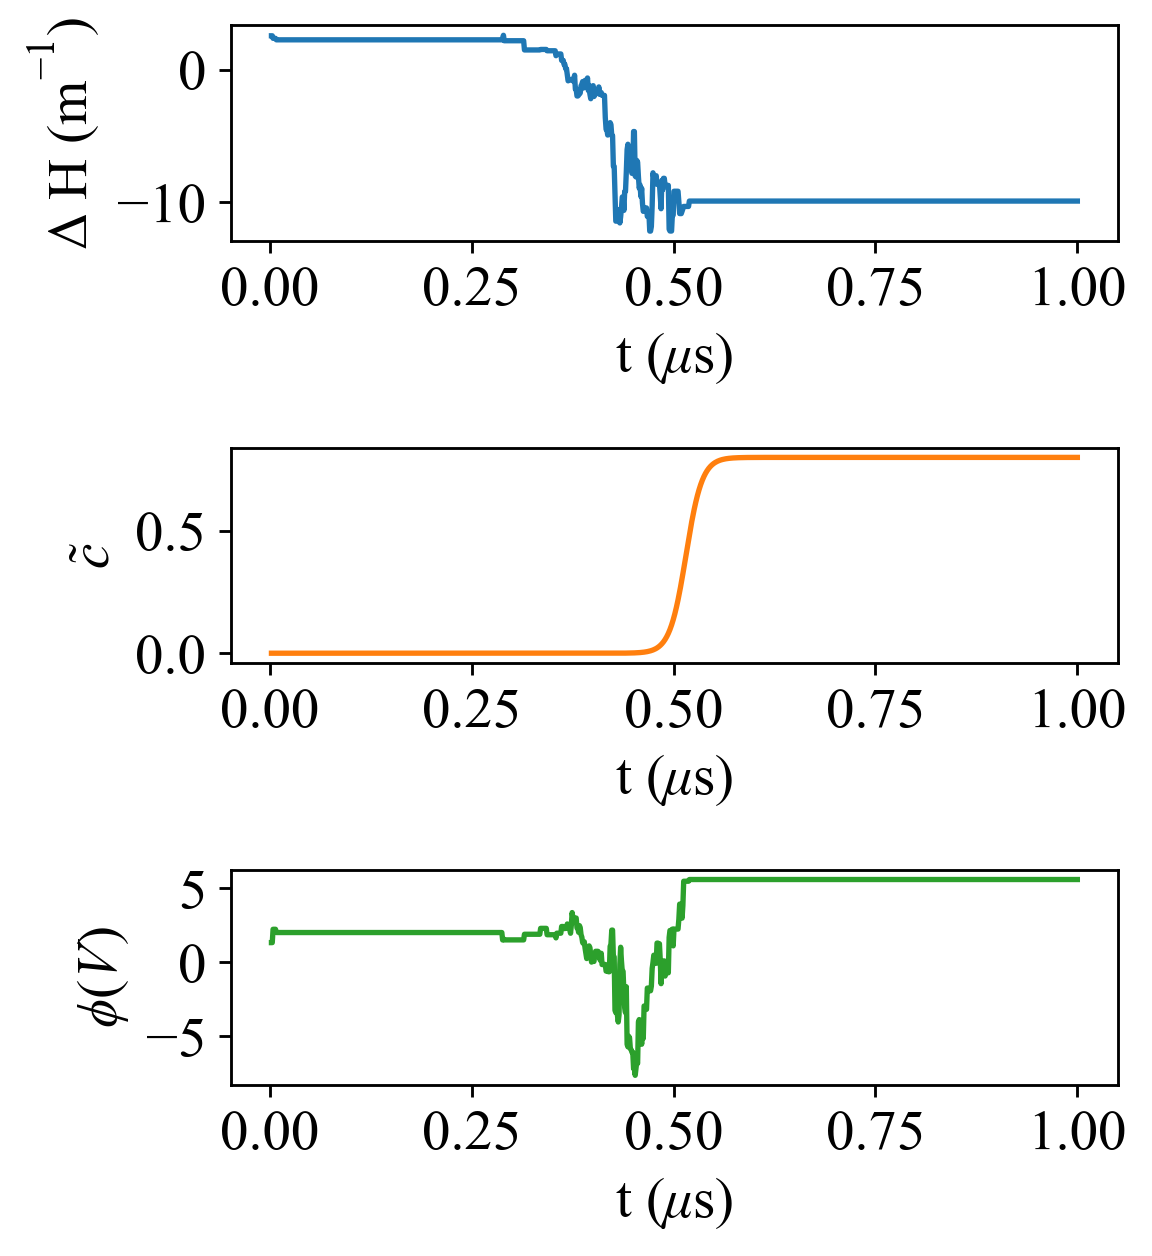

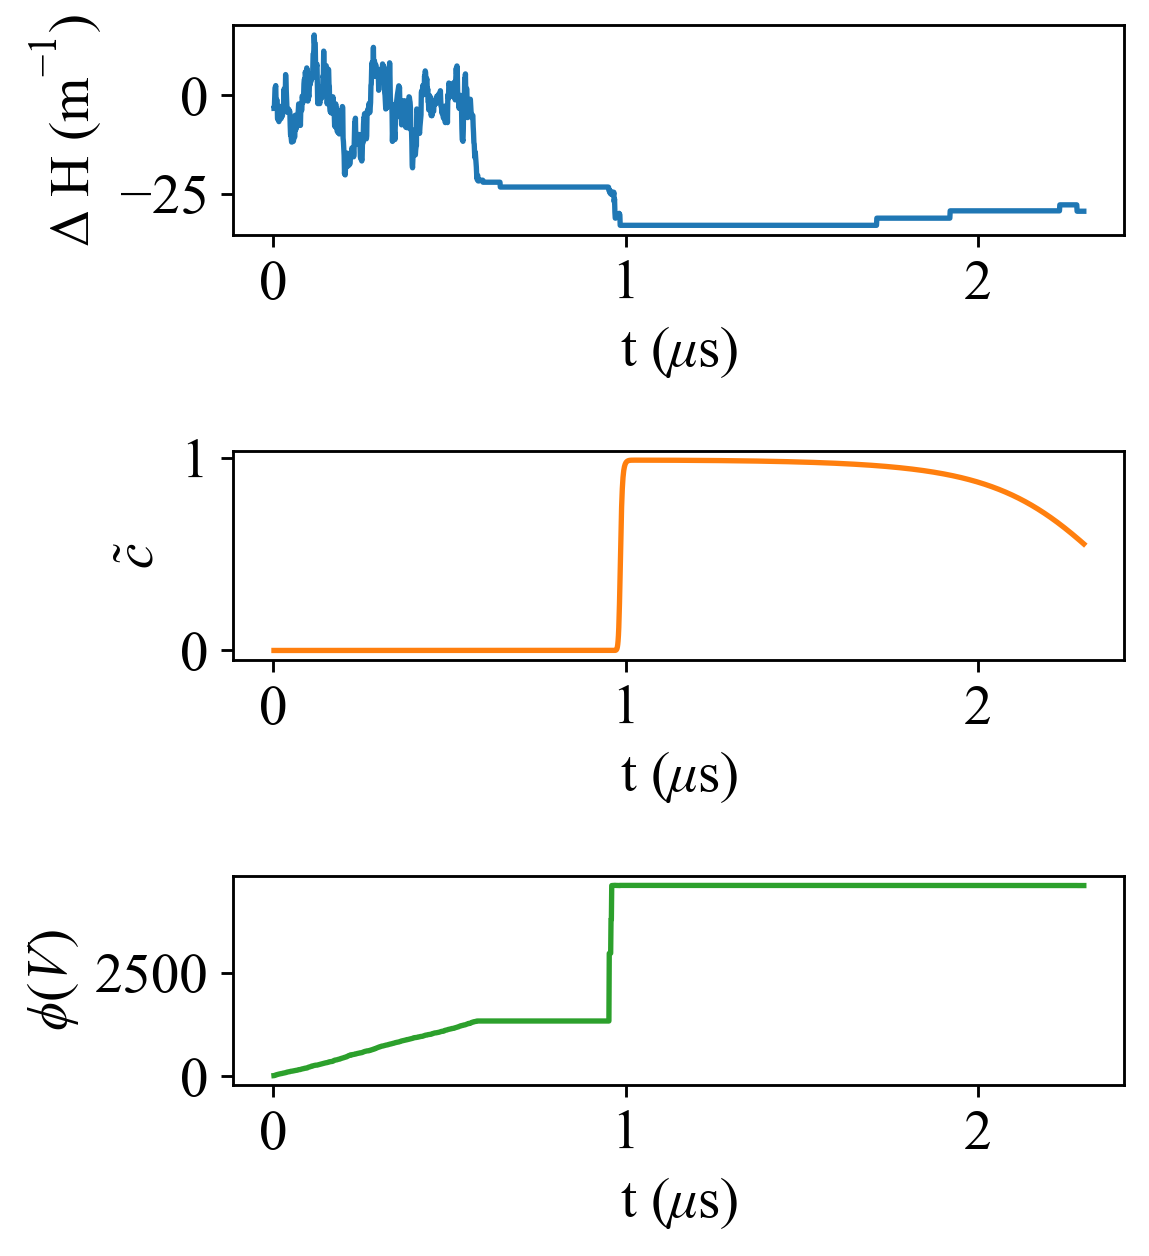

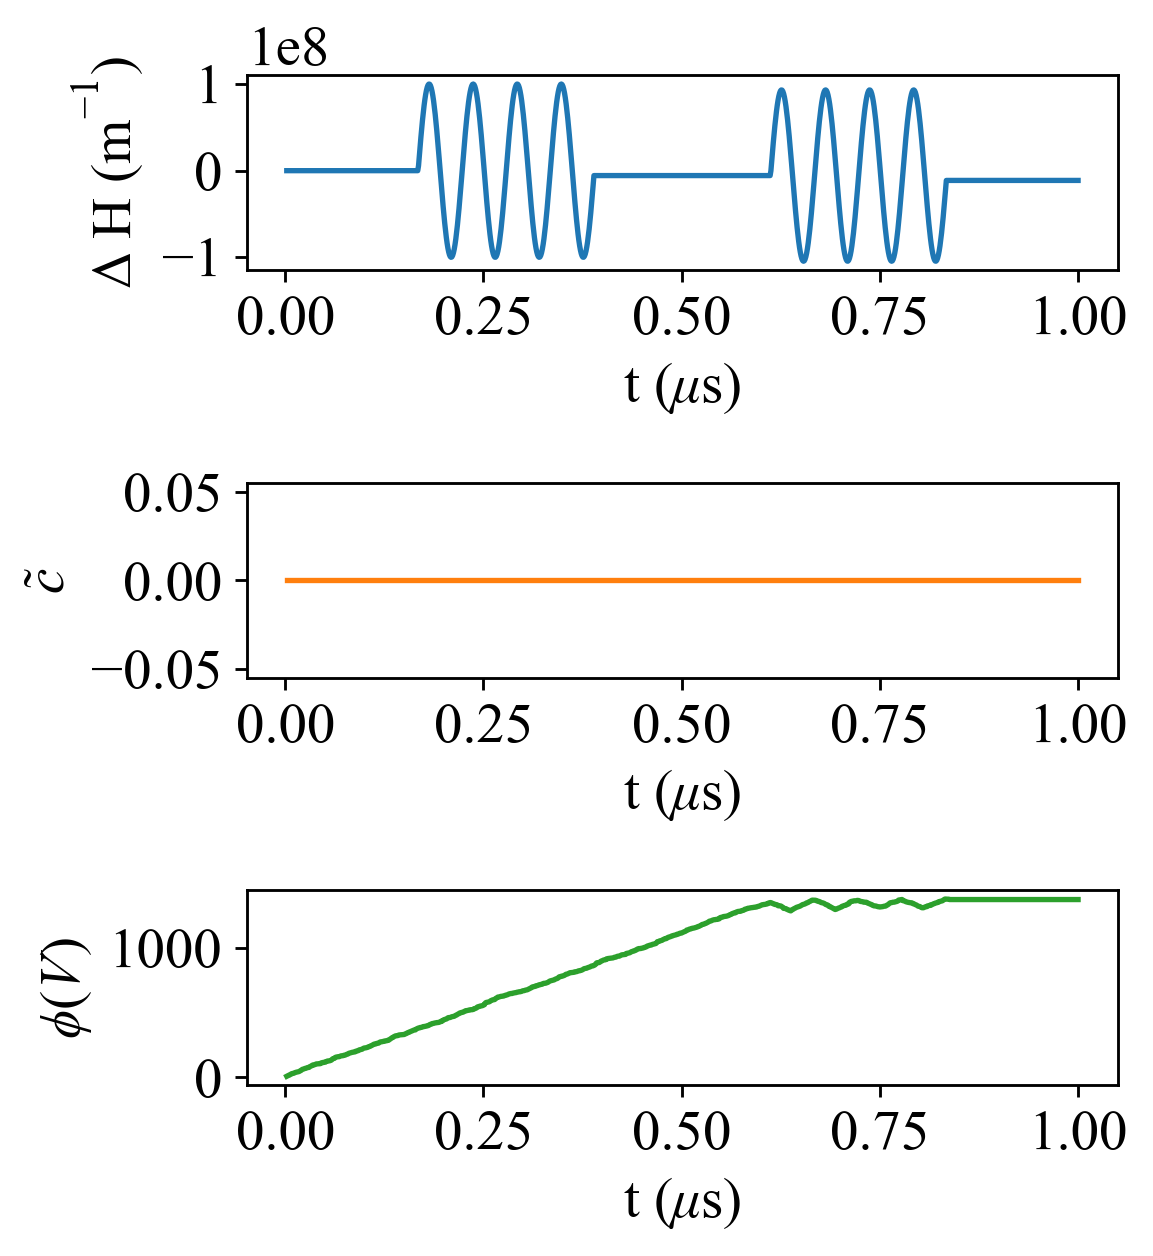

In [492]:
for filename in ['2None', '5Gaussian','0Sigmoid','2Skewwed', '6UltrasoundPulse']:
    X = np.loadtxt('data//X-'+filename+'.csv', delimiter=',')
    t = np.loadtxt('data//t-'+filename+'.csv', delimiter=',')
    
    fig, ax = plt.subplots(3,1, figsize = (1.61*linewidth/2, 1.75*linewidth/2))

    ax[0].plot(t[2:2300]*1e6, (X[2:2300,0]-5e8), label = r'$H$ (nm^1)')
    ax[0].set_ylim(ax[0].get_ylim()[0], ax[0].get_ylim()[1])
    ax[0].set_xlabel(r't ($\mu$s)')
    ax[0].set_ylabel('$\Delta$ H (m$^{-1}$)', rotation = 90)
    # ax[0].legend()

    plot1 = ax[1].plot(t[2:2300]*1e6, tilde(X[2:2300,1], c_0), color =  ax[0]._get_lines.get_next_color(), label = r'$c$')
    ax[1].set_xlabel(r't ($\mu$s)')
    ax[1].set_ylabel(r'$\tilde{c}$', rotation = 90)
    # ax[1].set_ylim(0, ax[1].get_ylim()[1])

    # ax1 = ax[1].twinx()
    # ax1.plot(t[2:], tilde(X[2:,1], c_0), ':', color =  ax[1].lines[-1].get_color(), label = r'$\tilde{c}$')
    # ax1.set_ylabel(r'$\tilde{c}$', rotation = 0)
    # ax1.set_ylim(0, ax1.get_ylim()[1])

    # handles0, labels0 = ax[1].get_legend_handles_labels()
    # handles1, labels1 = ax1.get_legend_handles_labels()
    # ax[1].legend(handles0+handles1, labels0+labels1, loc=[0.75, 0.4], frameon=False)

    ax[2].plot(t[2:2300]*1e6, X[2:2300,2], color =  ax[0]._get_lines.get_next_color(), label = r'$\phi$')
    ax[2].set_xlabel(r't ($\mu$s)', rotation = 0)
    ax[2].set_ylabel(r'$\phi (V)$', rotation = 90)
    ax[2].set_ylim(ax[2].get_ylim()[0], ax[2].get_ylim()[1])
    # ax[2].legend()

    # ax[2].set_ylim(0,10000)

    fig.tight_layout()
    fig.savefig('Figures'+ os.sep +filename+'.pdf', bbox_inches = 'tight')
    plt.show()